# Name: Ruta Misghina Gebremedhin
# ID: 500959486

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 20);">
    <h1 style="font-weight: bold; font-size: 50px;">Collaborative filtering using User-based rating prediction (UserKNN) and User-based
classification (UserKNN) </h1>
</div>


This document details the collaborative filtering pipeline for Assignment C, focusing on UserKNN-based rating prediction and classification. The workflow progresses from data preparation and sampling to baseline modeling, hyperparameter tuning, validation, and test evaluation.

We incorporate an alternative user-based strategy by modeling users’ average rating tendencies, enhancing predictive depth and behavioral interpretability.

Evaluation extends beyond RMSE and MAE to include novelty and diversity, reflecting a more holistic view of recommender quality. Models are validated across Movielens and Netflix datasets to confirm robustness and adaptability across domains.

All modeling steps are fully documented to ensure transparency, reproducibility, and applicability in broader contexts.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 108);">
    <h3 style="font-weight: bold; font-size: 50px;"> Movielens</h3>
</div>


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(9, 229, 9);">
    <h1 style="font-weight: bold; font-size: 36px;">0. Importing Packages and Libraries</h1>
</div>


In [ ]:
# Import necessary libraries
import os   # os for operating system related functions
import os.path   # os.path for handling file paths
import random   # random for generating random numbers
from datetime import datetime  # datetime module for working with dates and times

import pandas as pd  # pandas for data manipulation and analysis
import numpy as np   # numpy for numerical computations
import matplotlib.pyplot as plt  # matplotlib for plotting

from scipy.sparse import csr_matrix, issparse  # Import necessary functions for sparse matrices
from sklearn.neighbors import NearestNeighbors  # Import the NearestNeighbors class from scikit-learn
from sklearn.model_selection import train_test_split  # Import function to split data into train, validation, and test sets
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Import necessary functions for evaluating predictions

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(16, 229, 9);">
    <h1 style="font-weight: bold; font-size: 36px;">1. Preparing Dataset</h1>
</div>

We will first begin wiht the Movielens dataset

In [2]:
# Load Data for rating
def loadDataR(path):
    header = ['userid', 'itemid', 'rating', 'timestamp']
    df_rating= pd.read_csv(path, sep="::", names=header, engine="python")
    return df_rating
# Load Data for movie
def loadDataM(path):
    header = ['itemid', 'title', 'genre']
    df_movie = pd.read_csv(
        path,
        sep="::",
        names=header,
        engine="python",
        encoding="cp1252"  # ← handles special characters like é, ñ, etc.
    )
    return df_movie


df_rating=loadDataR(r"C:\Users\RUTA\Desktop\masters of digital driven bussines\SDM\SDM assigment\New folder\movielens\ratings.dat")
df_movies=loadDataM(r"C:\Users\RUTA\Desktop\masters of digital driven bussines\SDM\SDM assigment\New folder\movielens\movies.dat")


In [3]:
movielens = pd.merge(df_rating, df_movies, on='itemid', how='inner')
movielens 

,userid,itemid,rating,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,Weekend at Bernie's (1989),Comedy
1000205,6040,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,956715648,Sophie's Choice (1982),Drama


In [4]:
# Filter out users who have rated less than X percent of all movies
# Count the number of ratings for each movie and each user
ratings_per_movie = movielens.groupby('itemid').size().reset_index(name='ratings_per_movie')
ratings_per_user = movielens.groupby('userid').size().reset_index(name='number_rated')

# Set the threshold for the minimum percentage of movies a user must have rated
threshold_percentage = 0.02
print(f'Removing users who have rated less than {threshold_percentage*100}% of all movies')

# Filter out users who have rated less than the threshold percentage of movies
eligible_users = ratings_per_user[ratings_per_user['number_rated'] / ratings_per_movie.shape[0] > threshold_percentage]
movielens = movielens[movielens['userid'].isin(eligible_users['userid'])]

print(f'Filtered dataset size: {movielens.shape[0]}\n')

Removing users who have rated less than 2.0% of all movies
Filtered dataset size: 893591



In [5]:
# First, let's select the columns we need: itemid, title and genre
movies_unique = movielens[['itemid', 'title', 'genre']]

# Next, let's drop any duplicate movies
movies_unique = movies_unique.drop_duplicates(subset=['itemid'])


In [6]:
# Drop title, genres and year from the movielens dataset
movielens = movielens.drop(columns=['title', 'genre'])

CF can be computationally intensive on large datasets like Netflix or MovieLens.
To make experimentation faster and resource-efficient, we reduce the dataset size through **stratified sampling**:
- Rather than random sampling, we stratify based on the number of ratings per user to maintain the **distribution of user activity levels**.
- This ensures that the sampled dataset is still **representative** of the full dataset's user behavior patterns, which is critical for fair model evaluation. 
how we did the sampling is, We first measure user activity by counting how many ratings each user has given. Users are then grouped based on their activity level — active users (many ratings) and less active users (few ratings) are treated separately. During sampling, we preserve the original proportion of active and inactive users, ensuring that heavy raters remain equally represented. This maintains the natural rating patterns across popular and niche items. As a result, we obtain a much smaller, yet statistically representative dataset that allows faster model training without compromising behavioral realism.


This approach balances **efficiency** with **data integrity**, allowing quicker model iteration without compromising too much on performance fidelity.

In [7]:
from sklearn.model_selection import train_test_split

def stratified_sampling(df, sample_frac=0.1):
    """
    Performs stratified sampling to reduce dataset size while maintaining
    proportional representation of user activity levels.
    
    - `sample_frac`: Fraction of the dataset to keep (e.g., 0.1 for 10%)
    """
    # Step 1: Count number of ratings per user
    user_counts = df["userid"].value_counts()

    # Step 2: Create a temporary column for stratification
    df["user_rating_count"] = df["userid"].map(user_counts)

    # Step 3: Apply stratified sampling
    df_sampled, _ = train_test_split(df, test_size=(1 - sample_frac), stratify=df["user_rating_count"], random_state=42)

    # Step 4: Drop the temporary column
    df_sampled = df_sampled.drop(columns=["user_rating_count"])

    return df_sampled

# Apply stratified sampling (reduce dataset to 10%)
df_sampled = stratified_sampling(movielens, sample_frac=0.1)

# Print dataset sizes
print(f"Original dataset size: {len(movielens)}, Sampled dataset size: {len(df_sampled)}")


Original dataset size: 893591, Sampled dataset size: 89359


We want to visually compare the rating distribution between the main DataFrame (`movielens`) and the sampled DataFrame (`sample_df`). Plotting histograms of the 'rating' column for both datasets allows for a quick visual assessment of any differences or similarities in the rating distribution. This comparison can help evaluate the representativeness of the sampled dataset compared to the original dataset and understand any potential biases introduced during the sampling process.

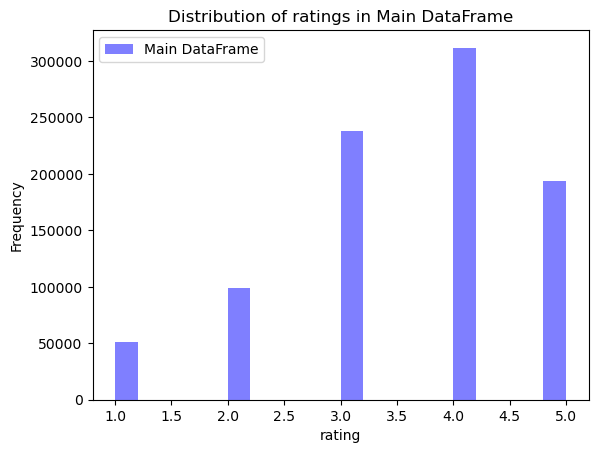

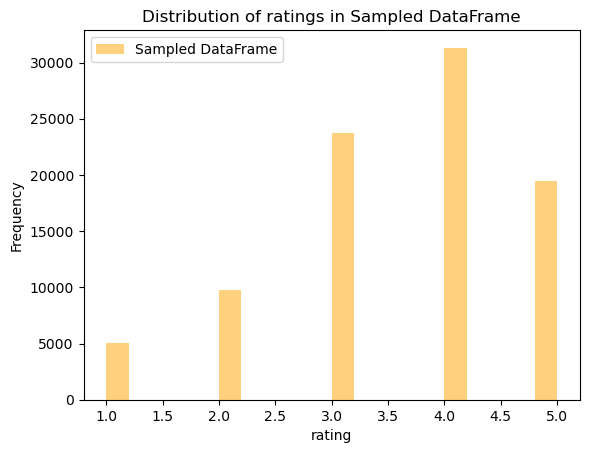

In [8]:
# Plot the distribution of a specific column in the main DataFrame
plt.hist(movielens['rating'], bins=20, color='blue', alpha=0.5, label='Main DataFrame')
plt.xlabel('rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings in Main DataFrame')
plt.legend()
plt.show()

# Plot the distribution of the same column in the sampled DataFrame
plt.hist(df_sampled['rating'], bins=20, color='orange', alpha=0.5, label='Sampled DataFrame')
plt.xlabel('rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings in Sampled DataFrame')
plt.legend()
plt.show()

Upon comparison of the plots, it is evident that the rating distribution in the sampled data frame closely mirrors that of the original dataset. This observation indicates that the sampling process effectively captured the variability and distribution of ratings in the primary data frame. Hence, the sampled dataset can represent the original dataset regarding rating distribution.

In User-based KNN, users have personal rating biases — some rate consistently high, others low. If uncorrected, these biases distort similarity calculations and harm prediction quality. To address this, we compute each user’s average rating (user_avg_ratings) and predict deviations from it. During prediction, we add back the user's mean to personalize the final rating. This adjustment normalizes rating habits, improving similarity accuracy, prediction fairness, and the overall recommendation quality.

In [21]:
# Step 1: Compute average rating per user
user_avg = df_sampled.groupby('userid')['rating'].mean().reset_index()
user_avg.rename(columns={'rating': 'avgratingperuser'}, inplace=True)

# Step 2: Merge and compute rating deviation
df_with_avg = df_sampled.merge(user_avg, on='userid')
df_with_avg['ratingdeviation_user'] = df_with_avg['rating'] - df_with_avg['avgratingperuser']
users = df_with_avg[['userid', 'avgratingperuser', 'ratingdeviation_user']]

# Step 3: Properly align user averages for KNN model
user_to_index = {uid: idx for idx, uid in enumerate(sorted(df_sampled['userid'].unique()))}
userid_to_avg = dict(zip(users['userid'], users['avgratingperuser']))
user_avg_ratings = np.array([userid_to_avg[uid] for uid in sorted(user_to_index.keys())])


Now that we've confirmed the adequacy of the data, we transform it into a matrix. This matrix will represent user-item interactions, where each row corresponds to a user, and each column corresponds to an item (movie). By converting the data into a matrix, we can efficiently analyze and model user-item relationships, facilitating tasks such as recommendation systems and collaborative filtering.

Making a matrix of the dataset.

In [22]:
def create_user_item_matrix(df, user_col, item_col, rating_col):
    # Count the number of unique users and items in the dataframe
    num_users = df[user_col].nunique()
    num_items = df[item_col].nunique()

    # Create dictionaries to map user and item IDs to their corresponding indices
    user_to_index = {user_id: index for index, user_id in enumerate(sorted(df[user_col].unique()))}
    item_to_index = {item_id: index for index, item_id in enumerate(sorted(df[item_col].unique()))}

    # Initialize lists to store data for creating the sparse user-item matrix
    rows = []
    cols = []
    data = []

    # Iterate over each row in the dataframe
    for _, row in df.iterrows():
        # Get the index of the user and item for the current row
        user_index = user_to_index[row[user_col]]
        item_index = item_to_index[row[item_col]]
        # Get the rating for the current user-item pair
        rating = row[rating_col]

        # Append the user index, item index, and rating to the respective lists
        rows.append(user_index)
        cols.append(item_index)
        data.append(rating)

    # Create a sparse user-item matrix using the data, rows, and columns lists
    user_item_matrix = csr_matrix((data, (rows, cols)), shape=(num_users, num_items))

    # Return the sparse user-item matrix
    return user_item_matrix


In [23]:
# Since we already a function to create the user-item matrix, we can use it here
user_item_matrix = create_user_item_matrix(df_sampled, 'userid', 'itemid', 'rating')
print(user_item_matrix)

  (0, 208)	3
  (0, 1006)	2
  (0, 1014)	3
  (0, 1054)	5
  (0, 1237)	4
  (0, 1298)	5
  (0, 1481)	4
  (0, 1546)	5
  (0, 1555)	5
  (0, 1912)	4
  (0, 2156)	3
  (0, 2358)	3
  (0, 2387)	3
  (0, 2551)	4
  (1, 33)	4
  (1, 49)	5
  (1, 190)	3
  (1, 243)	3
  (1, 263)	4
  (1, 533)	4
  (1, 1138)	4
  (1, 1225)	3
  (1, 1357)	3
  (1, 1379)	3
  (1, 1388)	4
  :	:
  (3481, 747)	3
  (3481, 959)	3
  (3481, 961)	3
  (3481, 973)	2
  (3481, 1011)	4
  (3481, 1025)	4
  (3481, 1055)	4
  (3481, 1075)	3
  (3481, 1140)	3
  (3481, 1348)	4
  (3481, 1349)	4
  (3481, 1392)	2
  (3481, 1452)	4
  (3481, 1563)	3
  (3481, 1610)	5
  (3481, 1874)	3
  (3481, 2110)	4
  (3481, 2259)	2
  (3481, 2265)	2
  (3481, 2417)	4
  (3481, 2578)	4
  (3481, 2584)	4
  (3481, 2779)	4
  (3481, 2921)	1
  (3481, 3096)	4


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 46);">
    <h2 style="font-weight: bold; font-size: 36px;">2. Baseline User Based rating Prediction</h2>
</div>


This model aims to provide movie recommendations to a target user, leveraging the preferences of similar users who share the same preferences as the target user. It accomplishes this by analyzing users' movie ratings, identifying movies they have rated highly, and suggesting those unseen movies to the target user. By utilizing similar users' preferences, the model aims to enhance the target user's movie-watching experience by recommending content tailored to their tastes.

In [24]:
# Generate a random integer representing a user index within the range of the number of rows in the user-item matrix
random_user = np.random.randint(user_item_matrix.shape[0])
# Print the randomly selected user index
print(f"Random user: {random_user}")

Random user: 2081


The randomly generated userid above corresponds to the user for whom the model will recommend ten movies.

The MovieRecommendationSystem is designed to generate personalized movie recommendations for a randomly selected user by using collaborative filtering. It begins by comparing the selected user's movie ratings to those of all other users, calculating cosine similarity to measure how closely their preferences match.

To refine these comparisons, the system applies a weighting function that adjusts the importance of certain similarities based on specific criteria, allowing for more precise recommendations.

After adjusting the similarity scores, the system identifies the users whose tastes most closely align with the selected user. It then analyzes the movies these similar users have rated highly and selects those films as potential recommendations. These movies are ranked based on their average ratings among similar users to ensure that the recommendations remain closely tied to the selected user's preferences.

If there are still open spots in the recommendation list, the system supplements it with popular movies the selected user has not yet rated. However, it only adds these popular films if there are not enough high-quality recommendations from similar users.

Finally, the system presents the top 10 recommended movies, including their titles, genres, and predicted ratings. By combining collaborative filtering techniques with user similarity metrics, the system delivers personalized movie suggestions that enhance the user's viewing experience and encourage greater engagement with the platform.

In [25]:
# Function to calculate cosine similarity between vectors
def user_user_matrix(vector1, vector2):
    # Compute the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)
    # Compute the product of the L2 norms of the two vectors
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    # Calculate the cosine similarity by dividing the dot product by the norm product, ensuring not to divide by zero
    return dot_product / norm_product if norm_product != 0 else 0

def recommend_items(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, k=10):
    # Calculate cosine similarity between users
    similarities = [(i, user_user_matrix(user_item_matrix[selected_user_index, :].toarray().flatten(), user_item_matrix[i, :].toarray().flatten())) 
                    for i in range(user_item_matrix.shape[0]) if i != selected_user_index]

    # Define a weight function to adjust similarities
    weight_function = lambda similarity: similarity * 2  # Example: doubling similarity values

    # Calculate weighted similarities between users
    weighted_similarities = [(i, weight_function(similarity)) for i, similarity in similarities]

    # Sort users based on weighted similarities (higher weights indicate stronger similarities)
    sorted_weighted_similarities = sorted(weighted_similarities, key=lambda x: x[1], reverse=True)

    # Use sorted weighted similarities for further processing (e.g., recommendation generation)
    # Select top similar users based on weighted similarities
    top_k_weighted_similar_users = sorted_weighted_similarities[:k]

    # Find recommended items based on ratings from similar users
    recommended_items = {}
    for user_index, similarity in top_k_weighted_similar_users:
        for item_index in items_not_seen:
            # Check if the item has been rated highly by the similar user
            if user_item_matrix[user_index, item_index] >= 4:
                # Update the recommended items dictionary with the maximum rating for each item
                recommended_items[item_index] = max(recommended_items.get(item_index, 0), user_item_matrix[user_index, item_index])

    # Sort recommended items by rating in descending order
    sorted_recommended_items = sorted(recommended_items.items(), key=lambda x: x[1], reverse=True)

    # Complete recommendations if not enough items have been recommended yet
    remaining_recommendations = 10 - len(sorted_recommended_items)
    if remaining_recommendations > 0:
        # Calculate the number of ratings for each item
        ratings_per_item = np.asarray((user_item_matrix != 0).sum(axis=0)).flatten()

        # Calculate the average rating for each item
        sum_ratings_per_item = np.asarray(user_item_matrix.sum(axis=0)).flatten()
        average_ratings_per_item = np.divide(sum_ratings_per_item, ratings_per_item, where=ratings_per_item != 0)

        # Filter items that the selected user has not seen
        unseen_popular_items_indices = [item_index for item_index in items_not_seen if ratings_per_item[item_index] > 0]

        # Sort the unseen items based on the number of ratings and average rating
        sorted_unseen_popular_items_indices = sorted(unseen_popular_items_indices, key=lambda x: (ratings_per_item[x], average_ratings_per_item[x]), reverse=True)

        # Select the top popular unseen items
        popular_unseen_items = [(item_index, 0) for item_index in sorted_unseen_popular_items_indices[:remaining_recommendations]]

        # Extend the list of recommended items with popular unseen items
        sorted_recommended_items.extend(popular_unseen_items)

        # Complete recommendations with random unseen items if needed
        remaining_random_recommendations = 10 - len(sorted_recommended_items)
        if remaining_random_recommendations > 0:
            # Select random unseen items from the remaining unseen items
            random_unseen_items = [i for i in items_not_seen if i not in [i for i, _ in sorted_recommended_items]]
            # Shuffle the list of random unseen items
            random.shuffle(random_unseen_items)
            # Extend the list of recommended items with random unseen items
            sorted_recommended_items.extend(random_unseen_items[:remaining_random_recommendations])

    # Display top 10 recommended items
    print(f"Similar users like you ({selected_user_index}) also liked:")
    for i, (item_index, rating) in enumerate(sorted_recommended_items[:10]):
        name = item_to_name.get(item_index, "Unknown Name")
        category = item_to_category.get(item_index)
        if category is None:
            category = name  # Show the title if no category is available
        print(f"{i+1}. itemid: {item_index}, Name: {name} - Category: {category}, Predicted rating: {rating}")


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 57);">
    <h3 style="font-weight: bold; font-size: 30px;">2.1 Baseline Prediction</h3>
</div>


As per usual we first start with the baseline prediction.

In [26]:
# Sample data: Select a random user index
selected_user_index = random_user

# Load item titles and genres
items = movies_unique.copy()

# Create dictionaries mapping item IDs to their titles and genres
item_to_name, item_to_category = dict(zip(items['itemid'], items['title'])), dict(zip(items['itemid'], items['genre']))
item_to_index = {item_id: index for index, item_id in enumerate(sorted(items['itemid'].unique()))}

# Get items that the user has not seen
# Find indices of items not yet seen by the selected user
items_not_seen_indices = np.where(user_item_matrix[selected_user_index, :].toarray().flatten() == 0)[0]
# Filter items not seen by the selected user based on available item indices
items_not_seen = [item_index for item_index in items_not_seen_indices if item_index in item_to_index]
# Call the function to get recommendations
recommend_items(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, k=5)


Similar users like you (2081) also liked:
1. itemid: 1037, Name: Lawnmower Man, The (1992) - Category: Action|Sci-Fi|Thriller, Predicted rating: 5
2. itemid: 2364, Name: Godzilla (Gojira) (1984) - Category: Action|Sci-Fi, Predicted rating: 5
3. itemid: 922, Name: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) - Category: Film-Noir, Predicted rating: 5
4. itemid: 1237, Name: Seventh Seal, The (Sjunde inseglet, Det) (1957) - Category: Drama, Predicted rating: 5
5. itemid: 477, Name: What's Love Got to Do with It? (1993) - Category: Drama, Predicted rating: 5
6. itemid: 666, Name: All Things Fair (1996) - Category: Drama, Predicted rating: 5
7. itemid: 1865, Name: Wild Man Blues (1998) - Category: Documentary, Predicted rating: 5
8. itemid: 1954, Name: Rocky (1976) - Category: Action|Drama, Predicted rating: 5
9. itemid: 2475, Name: 52 Pick-Up (1986) - Category: Action|Mystery|Thriller, Predicted rating: 4
10. itemid: 2871, Name: Deliverance (1972) - Category: Adventure|Thriller, Predicted

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 82);">
    <h2 style="font-weight: bold; font-size: 36px;">2.2 Hyperparameter Tuning</h2>
</div>


Now that we have a functional model, our next step is performing hyperparameter tuning. Specifically, in the case of the K-Nearest Neighbors (KNN) algorithm, we aim to determine the optimal value for the hyperparameter K. Hyperparameter tuning involves systematically searching for the best value of K that maximizes the performance of the KNN model. By finding the most suitable K value, we can enhance the accuracy and effectiveness of our recommendation system, ensuring it provides users with the most relevant and accurate movie recommendations.

We begin by defining several functions essential for fine-tuning the model.

This function train_test takes a dataframe containing user-item ratings as input and performs the following operations:

Removes duplicate entries from the dataframe.
Creates a user-item matrix with ratings by pivoting the dataframe, filling missing values with 0.
Splits the user-item matrix into train, validation, and test sets using the train_test_split function from scikit-learn.
Converts the train, validation, and test datasets into sparse matrices using the csr_matrix function from SciPy.
Returns the train, validation, and test datasets as sparse matrices.

In [28]:
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def train_test_sparse(df, user_col='userid', item_col='itemid', rating_col='rating', time_col='timestamp'):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], unit='s')

    # ➡ Step 1: Filter out users with <5 ratings
    user_counts = df[user_col].value_counts()
    active_users = user_counts[user_counts >= 5].index
    df = df[df[user_col].isin(active_users)]

    # ➡ Step 2: Create mappings AFTER filtering
    user_to_index = {uid: idx for idx, uid in enumerate(sorted(df[user_col].unique()))}
    item_to_index = {iid: idx for idx, iid in enumerate(sorted(df[item_col].unique()))}

    df['user_index'] = df[user_col].map(user_to_index)
    df['item_index'] = df[item_col].map(item_to_index)

    num_users = len(user_to_index)
    num_items = len(item_to_index)

    # ➡ Step 3: Initialize sparse matrices
    train = lil_matrix((num_users, num_items), dtype=np.float32)
    val = lil_matrix((num_users, num_items), dtype=np.float32)
    test = lil_matrix((num_users, num_items), dtype=np.float32)

    # ➡ Step 4: Time-aware split
    for user_idx, group in df.groupby('user_index'):
        group_sorted = group.sort_values(time_col)
        n = len(group_sorted)

        train_end = int(n * 0.6)
        val_end = int(n * 0.8)

        for _, row in group_sorted.iloc[:train_end].iterrows():
            train[row['user_index'], row['item_index']] = row[rating_col]
        for _, row in group_sorted.iloc[train_end:val_end].iterrows():
            val[row['user_index'], row['item_index']] = row[rating_col]
        for _, row in group_sorted.iloc[val_end:].iterrows():
            test[row['user_index'], row['item_index']] = row[rating_col]

    return train.tocsr(), val.tocsr(), test.tocsr(), user_to_index, item_to_index


The function `evaluate_predictions` assesses prediction models' accuracy by calculating two key metrics: Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). 


In [ ]:
def evaluate_predictions(pred_matrix, truth_matrix):
    rows, cols = truth_matrix.nonzero()
    truth = []
    pred = []

    for u, i in zip(rows, cols):
        truth.append(truth_matrix[u, i])
        pred.append(pred_matrix[u, i])

    truth = np.array(truth).flatten()
    pred = np.array(pred).flatten()

    rmse = np.sqrt(mean_squared_error(truth, pred))
    mae = mean_absolute_error(truth, pred)
    return rmse, mae


This function `predict_user_based_knn_with_mean` predicts user-item ratings using a user-based K-nearest neighbors (UserKNN) approach with mean-centering based on the computed user means from the training data. It first calculates each user's average rating and centers the training matrix by subtracting these averages. Then it computes cosine similarity between users on the mean-centered matrix. For each nonzero entry in the target matrix, it identifies the k most similar users (excluding the user itself), aggregates their centered ratings weighted by the similarity scores, and adds back the user's mean rating to predict the final score. If none of the neighbors rated the item, the user's mean rating is used as a fallback prediction.


In [30]:
def predict_user_based_knn_with_mean(train_matrix, target_matrix, k=5):
    num_users, num_items = train_matrix.shape

    # Step 1: Compute user mean ratings
    user_means = np.array(train_matrix.sum(axis=1)).flatten() / (train_matrix != 0).sum(axis=1).A1
    user_means = np.nan_to_num(user_means)

    # Step 2: Mean-center train matrix (copy to avoid mutation)
    train_centered = train_matrix.copy().tolil()
    for u in range(num_users):
        for i in train_centered.rows[u]:
            train_centered[u, i] -= user_means[u]
    train_centered = train_centered.tocsr()

    # Step 3: Compute user-user cosine similarity
    similarity = cosine_similarity(train_centered)

    # Step 4: Predict for each nonzero entry in target matrix
    predictions = np.zeros(target_matrix.shape)

    for u in range(num_users):
        sim_users = similarity[u]
        top_k_users = np.argsort(sim_users)[-k-1:-1][::-1]  # top K excluding self

        for i in target_matrix[u].nonzero()[1]:
            num, denom = 0.0, 0.0
            for v in top_k_users:
                r = train_centered[v, i]
                if r != 0:
                    num += sim_users[v] * r
                    denom += abs(sim_users[v])
            if denom != 0:
                pred = num / denom + user_means[u]
            else:
                pred = user_means[u]  # fallback
            predictions[u, i] = pred

    return predictions



This function `calculate_weighted_knn_prediction_with_avg` also performs user-based K-nearest neighbors (UserKNN) prediction with mean-centering, but instead of computing user means from the training data, it uses externally provided user average ratings (for example, precomputed averages from a different sampling process). The function first centers the training matrix using these given averages, computes cosine similarity between users based on the centered data, and predicts ratings for nonzero entries in the target matrix. It selects the k most similar users for each prediction, weights their contributions by similarity scores, and re-adds the user’s provided average rating to generate the final prediction. If no neighbors contribute, the user’s average rating is used as a default.

In [31]:
def calculate_weighted_knn_prediction_with_avg(train_matrix, target_matrix, user_avg_ratings, k=5):
    num_users, num_items = train_matrix.shape

    # Step 1: Mean-center train matrix (copy to avoid mutation)
    train_centered = train_matrix.copy().tolil()
    for u in range(num_users):
        for i in train_centered.rows[u]:
            train_centered[u, i] -= user_avg_ratings[u]
    train_centered = train_centered.tocsr()

    # Step 2: Compute cosine similarity
    similarity = cosine_similarity(train_centered)

    # Step 3: Predict for each nonzero entry in target matrix
    predictions = np.zeros(target_matrix.shape)

    for u in range(num_users):
        sim_users = similarity[u]
        top_k_users = np.argsort(sim_users)[-k-1:-1][::-1]  # top K excluding self

        for i in target_matrix[u].nonzero()[1]:
            num, denom = 0.0, 0.0
            for v in top_k_users:
                r = train_centered[v, i]
                if r != 0:
                    num += sim_users[v] * r
                    denom += abs(sim_users[v])
            if denom != 0:
                pred = num / denom + user_avg_ratings[u]
            else:
                pred = user_avg_ratings[u]  # fallback
            predictions[u, i] = pred

    return predictions


The function `hyper_parameter_tuning_knn` tunes the number of neighbors (k) for UserKNN using validation RMSE over multiple iterations, with optional external user averages.

In [32]:
def hyperparameter_tuning_user_knn(dataset, iterations=3, k_values=None, use_avg_ratings_option=False, user_avg_ratings=None, user_col='userid', item_col='itemid', rating_col='rating', time_col='timestamp'):
    if k_values is None:
        k_values = [5, 10, 20, 30, 40, 50]

    results = []

    for k in k_values:
        rmse_list, mae_list = [], []

        for _ in range(iterations):
            train_mat, val_mat, _, _, _ = train_test_sparse(
                dataset,
                user_col=user_col,
                item_col=item_col,
                rating_col=rating_col,
                time_col=time_col
            )

            if use_avg_ratings_option:
                pred = calculate_weighted_knn_prediction_with_avg(train_mat, val_mat, user_avg_ratings, k=k)
            else:
                pred = predict_user_based_knn_with_mean(train_mat, val_mat, k=k)

            rmse, mae = evaluate_predictions(pred, val_mat)

            rmse_list.append(rmse)
            mae_list.append(mae)

        avg_rmse = np.mean(rmse_list)
        avg_mae = np.mean(mae_list)

        print(f"[k={k}] RMSE={avg_rmse:.4f}, MAE={avg_mae:.4f}")
        results.append((avg_rmse, avg_mae, k))

    best = sorted(results, key=lambda x: x[0])[0]
    print(f"\nBest k: {best[2]} → Validation RMSE={best[0]:.4f}, MAE={best[1]:.4f}")
    return best


The line of code initiates hyperparameter tuning for the KNN (K-Nearest Neighbors) model, an essential step in model development. By passing the `sample_df` dataset the function `hyper_parameter_tuning_knn` undertakes multiple iterations of hyperparameter optimization. This iterative approach allows for a thorough exploration of the hyperparameter space, aiming to find the most effective model configuration. Upon completion of the tuning process, the best hyperparameters for the KNN model are stored in the variable `best_parameters_normal` and are ready for subsequent model training and evaluation. Hyperparameter tuning is crucial for optimizing model performance and enhancing predictive accuracy in machine learning applications.

In [47]:
best_result = hyperparameter_tuning_user_knn(df_sampled, iterations=2, k_values=[5, 10, 20, 30, 40, 50], use_avg_ratings_option=False,           
    user_avg_ratings=user_avg_ratings,       
    user_col='userid',
    item_col='itemid',
    rating_col='rating',
    time_col='timestamp')



[k=5] RMSE=1.0930, MAE=0.8572
[k=10] RMSE=1.1056, MAE=0.8649
[k=20] RMSE=1.1314, MAE=0.8801
[k=30] RMSE=1.1530, MAE=0.8963
[k=40] RMSE=1.1653, MAE=0.9061
[k=50] RMSE=1.1788, MAE=0.9174

Best k: 5 → Validation RMSE=1.0930, MAE=0.8572


Observations:
- As the value of k increases, RMSE and MAE generally increase, indicating a decrease in prediction accuracy.
- The best performance, in terms of both RMSE and MAE, is achieved when k=5, with RMSE=1.0930, MAE=0.8572

Therefore, when using cosine similarity without averaging ratings per user, it is optimal to choose k=5 to achieve the best prediction accuracy based on the provided data.

After our baseline we perform hyperparameter tuning, we can use all of our previous functions again.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 9);">
    <h2 style="font-weight: bold; font-size: 36px;">2.3 Using Best Hyperparameter for user-based KNN</h2>
</div>


Below we created a function to test our KNN model.

In [48]:
def test_user_knn_model(dataset, best_k, use_avg_ratings_option=False, user_avg_ratings=None, user_col='userid', item_col='itemid', rating_col='rating', time_col='timestamp'):
    # Full time-aware split
    train_mat, _, test_mat, _, _ = train_test_sparse(
        dataset, 
        user_col=user_col, 
        item_col=item_col, 
        rating_col=rating_col, 
        time_col=time_col
    )

    # Predict depending if average rating correction is enabled
    if use_avg_ratings_option:
        test_pred = calculate_weighted_knn_prediction_with_avg(train_mat, test_mat, user_avg_ratings, k=best_k)
    else:
        test_pred = predict_user_based_knn_with_mean(train_mat, test_mat, k=best_k)

    # Evaluate
    rmse_test, mae_test = evaluate_predictions(test_pred, test_mat)
    print(f"[TEST] Final model with k={best_k} → RMSE={rmse_test:.4f}, MAE={mae_test:.4f}")

    return rmse_test, mae_test


In [49]:
final_k = best_result[2]  # Extract best k from tuning
test_rmse, test_mae = test_user_knn_model(df_sampled, best_k=final_k)

[TEST] Final model with k=5 → RMSE=1.1317, MAE=0.8883


In [50]:

# Call the function to get recommendations with the best K to see if we get different results from our baseline prediction recommender 
recommend_items(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, k=final_k)

Similar users like you (2081) also liked:
1. itemid: 1037, Name: Lawnmower Man, The (1992) - Category: Action|Sci-Fi|Thriller, Predicted rating: 5
2. itemid: 2364, Name: Godzilla (Gojira) (1984) - Category: Action|Sci-Fi, Predicted rating: 5
3. itemid: 922, Name: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) - Category: Film-Noir, Predicted rating: 5
4. itemid: 1237, Name: Seventh Seal, The (Sjunde inseglet, Det) (1957) - Category: Drama, Predicted rating: 5
5. itemid: 477, Name: What's Love Got to Do with It? (1993) - Category: Drama, Predicted rating: 5
6. itemid: 666, Name: All Things Fair (1996) - Category: Drama, Predicted rating: 5
7. itemid: 1865, Name: Wild Man Blues (1998) - Category: Documentary, Predicted rating: 5
8. itemid: 1954, Name: Rocky (1976) - Category: Action|Drama, Predicted rating: 5
9. itemid: 2475, Name: 52 Pick-Up (1986) - Category: Action|Mystery|Thriller, Predicted rating: 4
10. itemid: 2871, Name: Deliverance (1972) - Category: Adventure|Thriller, Predicted

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 75);">
    <h1 style="font-weight: bold; font-size: 36px;">3. User-based classification using KNN</h1>
</div>


Now that we've utilized predictions, our next step is to classify users to identify similarities among them. This classification task can be accomplished using the KNN algorithm.

In [51]:
# To freshen up our mind, we print the random user we used before again.
print(random_user)

2081


The function, `user_user_similarity`, aims to calculate the similarities between a selected user and other users based on their interactions with items. It first converts a sparse matrix representing these interactions into a dense array for easy computation. Then, it iterates over each user, except the selected one, computing the cosine similarity between their interaction vectors. The function returns a list of tuples, each containing the index of another user and their similarity score with the selected user. Afterwards, a random user index is chosen, and similarities between this user and others are calculated. The resulting similarities are sorted in descending order, and the top 20 similar users are displayed along with their similarity scores. Overall, the code facilitates the analysis of user-user similarities in item interaction data.

In [52]:
# Define a function to calculate user-user similarity
def user_user_similarity(user_item_matrix, selected_user_index):
    # Convert the sparse matrix to a dense array
    user_item_matrix_dense = user_item_matrix.toarray()

    # Calculate cosine similarity between the selected user and other users
    similarities = []  # Initialize a list to store user similarities
    selected_user_vector = user_item_matrix_dense[selected_user_index]  # Get the vector for the selected user
    for i in range(user_item_matrix_dense.shape[0]):  # Iterate over all users
        if i != selected_user_index:  # Skip the selected user
            other_user_vector = user_item_matrix_dense[i]  # Get the vector for another user
            # Calculate cosine similarity between the selected user and another user
            similarity = np.dot(selected_user_vector, other_user_vector) / (np.linalg.norm(selected_user_vector) * np.linalg.norm(other_user_vector))
            similarities.append((i, similarity))  # Store the similarity between users
    return similarities  # Return list of user similarities

# Sample data: Select a random user index
selected_user_index = random_user

# Calculate similarities between the selected user and other users
similarities = user_user_similarity(user_item_matrix, selected_user_index)

# Sort the similarities in descending order
sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

# Display similar users
print(f"Users similar to user {selected_user_index}:")
for user_index, similarity in sorted_similarities[:20]:  # Display top X similar users
    print(f"User {user_index} - Similarity: {similarity:.2f}")  # Print user index and similarity score


Users similar to user 2081:
User 95 - Similarity: 0.20
User 308 - Similarity: 0.18
User 865 - Similarity: 0.17
User 3030 - Similarity: 0.17
User 2925 - Similarity: 0.17
User 1160 - Similarity: 0.16
User 2254 - Similarity: 0.16
User 1756 - Similarity: 0.16
User 414 - Similarity: 0.15
User 3408 - Similarity: 0.15
User 1422 - Similarity: 0.15
User 1457 - Similarity: 0.14
User 2891 - Similarity: 0.14
User 3042 - Similarity: 0.14
User 2904 - Similarity: 0.14
User 2516 - Similarity: 0.14
User 2666 - Similarity: 0.14
User 1751 - Similarity: 0.13
User 2332 - Similarity: 0.13
User 1923 - Similarity: 0.13


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 57);">
    <h2 style="font-weight: bold; font-size: 36px;">4. Predicting Using Similarity on Average rating per User </h2>
</div>

The previous predictions were done by finding users who rated similar movies high, in this section we will look into another feature: average rating per user.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 27);">
    <h2 style="font-weight: bold; font-size: 36px;">4.1 Baseline Prediction </h2>
</div>

The functions `user_user_matrix` and `recommend_items_with_avg_rating_user` work together to recommend items to a user based on the preferences of similar users. The process works as follows:

1. **Calculate Similarities**: It measures how similar the selected user is to all other users based on their item interaction vectors, using cosine similarity.

2. **Adjust Similarities**: It adjusts the similarity scores by weighting them based on the difference in users' average ratings. Users who have similar tastes and similar rating habits are weighted more heavily.

3. **Select Top Similar Users**: It selects the top `k` users who are most similar to the selected user after weighting.

4. **Recommend Highly Rated Items**: It identifies items that these top similar users rated highly (with a rating of 4 or above) and recommends them to the selected user, ensuring they are items the user has not seen yet.

5. **Fill Remaining Recommendations**: If there are fewer than 10 recommendations, it adds popular unseen items, prioritizing items with more ratings and higher average ratings.

6. **Random Fill-in if Needed**: If there are still fewer than 10 items, it randomly selects unseen items to complete the recommendation list.

7. **Display Recommendations**: Finally, it prints the top 10 recommended items, showing the item ID, name, category, and predicted rating to help the user understand the suggestions.


In [63]:
# Function to calculate the cosine similarity between two vectors
def user_user_matrix(vector1, vector2):
    dot_product = np.dot(vector1, vector2)  # Calculate dot product of the two vectors
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)  # Calculate product of their norms
    return dot_product / norm_product if norm_product != 0 else 0  # Return cosine similarity if denominator is not zero, otherwise return 0

def recommend_items_with_avg_rating_user(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, k=10):
    # Calculate similarities between the selected user and other users
    similarities = [(i, user_user_matrix(user_item_matrix[selected_user_index, :].toarray().flatten(), user_item_matrix[i, :].toarray().flatten())) 
                    for i in range(user_item_matrix.shape[0]) if i != selected_user_index]

    # Define a weight function to adjust similarities based on average ratings
    selected_user_avg_rating = user_avg_ratings[selected_user_index]
    weight_function = lambda similarity, avg_rating: similarity * (1 + abs(selected_user_avg_rating - avg_rating))

    # Apply the weight function to similarities
    weighted_similarities = [(i, weight_function(similarity, user_avg_ratings[i])) for i, similarity in similarities]

    # Sort the weighted similarities in descending order
    sorted_weighted_similarities = sorted(weighted_similarities, key=lambda x: x[1], reverse=True)

    # Select the top k similar users
    top_k_weighted_similar_users = sorted_weighted_similarities[:k]

    # Initialize a dictionary to store recommended items
    recommended_items = {}

    # Iterate through top similar users and unseen items to recommend
    for user_index, similarity in top_k_weighted_similar_users:
        for item_index in items_not_seen:
            if user_item_matrix[user_index, item_index] >= 4:  # If the user rated the item highly
                recommended_items[item_index] = max(recommended_items.get(item_index, 0), user_item_matrix[user_index, item_index])  # Update recommendation if necessary

    # Sort recommended items by predicted rating
    sorted_recommended_items = sorted(recommended_items.items(), key=lambda x: x[1], reverse=True)

    # Ensure we have at most 10 recommendations
    remaining_recommendations = 10 - len(sorted_recommended_items)
    if remaining_recommendations > 0:
        # Calculate the number of ratings for each item
        ratings_per_item = np.asarray((user_item_matrix != 0).sum(axis=0)).flatten()

        # Calculate the average rating for each item
        sum_ratings_per_item = np.asarray(user_item_matrix.sum(axis=0)).flatten()
        average_ratings_per_item = np.divide(sum_ratings_per_item, ratings_per_item, where=ratings_per_item != 0)

        # Filter items that the selected user has not seen
        unseen_popular_items_indices = [item_index for item_index in items_not_seen if ratings_per_item[item_index] > 0]

        # Sort the unseen items based on the number of ratings and average rating
        sorted_unseen_popular_items_indices = sorted(unseen_popular_items_indices, key=lambda x: (ratings_per_item[x], average_ratings_per_item[x]), reverse=True)

        # Select the top popular unseen items
        popular_unseen_items = [(item_index, 0) for item_index in sorted_unseen_popular_items_indices[:remaining_recommendations]]

        # Extend recommendations with popular unseen items
        sorted_recommended_items.extend(popular_unseen_items)

        # Ensure we still have at most 10 recommendations
        remaining_random_recommendations = 10 - len(sorted_recommended_items)
        if remaining_random_recommendations > 0:
            # Add random unseen items to reach 10 recommendations
            random_unseen_items = [i for i in items_not_seen if i not in [i for i, _ in sorted_recommended_items]]
            random.shuffle(random_unseen_items)
            sorted_recommended_items.extend(random_unseen_items[:remaining_random_recommendations])

    # Print recommended items
    print(f"Similar users like you ({selected_user_index}) also loved:")
    for i, (item_index, rating) in enumerate(sorted_recommended_items[:10]):
        name = item_to_name.get(item_index, "Unknown Name")
        category = item_to_category.get(item_index, "Unknown Category")
        print(f"{i+1}. itemid: {item_index}, Name: {name} - Category: {category}, Predicted rating: {rating}")

# Call the function to get recommendations
recommend_items_with_avg_rating_user(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, k=10)

Similar users like you (2081) also loved:
1. itemid: 2364, Name: Godzilla (Gojira) (1984) - Category: Action|Sci-Fi, Predicted rating: 5
2. itemid: 2966, Name: Straight Story, The (1999) - Category: Drama, Predicted rating: 5
3. itemid: 961, Name: Little Lord Fauntleroy (1936) - Category: Drama, Predicted rating: 5
4. itemid: 1569, Name: My Best Friend's Wedding (1997) - Category: Comedy|Romance, Predicted rating: 5
5. itemid: 922, Name: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) - Category: Film-Noir, Predicted rating: 5
6. itemid: 1237, Name: Seventh Seal, The (Sjunde inseglet, Det) (1957) - Category: Drama, Predicted rating: 5
7. itemid: 533, Name: Shadow, The (1994) - Category: Action, Predicted rating: 5
8. itemid: 867, Name: Carpool (1996) - Category: Comedy|Crime, Predicted rating: 5
9. itemid: 1889, Name: Insomnia (1997) - Category: Thriller, Predicted rating: 5
10. itemid: 1422, Name: Murder at 1600 (1997) - Category: Mystery|Thriller, Predicted rating: 5


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 20);">
    <h2 style="font-weight: bold; font-size: 36px;">4.2 Hyperparameter tuning </h2>
</div>

Now that we have established our baseline, we proceed with the usual hyperparameter tuning process.

In [54]:
# Now doing some hyperparameter tuning with average ratings
best_parameters_with_avg = hyperparameter_tuning_user_knn(df_sampled, iterations=2, k_values=[5, 10, 20, 30, 40, 50], use_avg_ratings_option=True,           
    user_avg_ratings=user_avg_ratings,       
    user_col='userid',
    item_col='itemid',
    rating_col='rating',
    time_col='timestamp')

[k=5] RMSE=1.2245, MAE=0.9689
[k=10] RMSE=1.2336, MAE=0.9754
[k=20] RMSE=1.2472, MAE=0.9852
[k=30] RMSE=1.2635, MAE=0.9956
[k=40] RMSE=1.2766, MAE=1.0051
[k=50] RMSE=1.2892, MAE=1.0146

Best k: 5 → Validation RMSE=1.2245, MAE=0.9689


Observations:

- The RMSE and MAE decrease as the value of k (number of neighbours) increases.
- As k increases, the model performs better in prediction accuracy.
- The best performance is achieved when k=5, with RMSE=1.2245, MAE=0.9689.

Therefore, when employing cosine similarity with average ratings per user, choosing a K=5 to achieve the best prediction accuracy based on the given data is optimal.

After hyperparameter tuning we use the best found K on the test set.

In [60]:
best_k_with_avg = best_result[2]  # Extract best k from tuning
# Testing the model with the best k and average ratings 
test_rmse_with_avg, test_mae_with_avg = test_user_knn_model(df_sampled, best_k_with_avg,use_avg_ratings_option=True, user_avg_ratings=user_avg_ratings)
print(f"Results for approach with average ratings per user: Test RMSE: {test_rmse_with_avg:.4f}, Test MAE: {test_mae_with_avg:.4f}")


[TEST] Final model with k=5 → RMSE=1.2391, MAE=0.9827
Results for approach with average ratings per user: Test RMSE: 1.2391, Test MAE: 0.9827


With the newly found best K we want to see the effect it has on the recommendations.

In [64]:
# Using the best k and average ratings to recommend items to the user to see if we get different results
recommend_items_with_avg_rating_user(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, k=best_k_with_avg)

Similar users like you (2081) also loved:
1. itemid: 2364, Name: Godzilla (Gojira) (1984) - Category: Action|Sci-Fi, Predicted rating: 5
2. itemid: 2966, Name: Straight Story, The (1999) - Category: Drama, Predicted rating: 5
3. itemid: 961, Name: Little Lord Fauntleroy (1936) - Category: Drama, Predicted rating: 5
4. itemid: 1569, Name: My Best Friend's Wedding (1997) - Category: Comedy|Romance, Predicted rating: 5
5. itemid: 922, Name: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) - Category: Film-Noir, Predicted rating: 5
6. itemid: 1237, Name: Seventh Seal, The (Sjunde inseglet, Det) (1957) - Category: Drama, Predicted rating: 5
7. itemid: 423, Name: Blown Away (1994) - Category: Action|Thriller, Predicted rating: 4
8. itemid: 889, Name: 1-900 (1994) - Category: Romance, Predicted rating: 4
9. itemid: 963, Name: Inspector General, The (1949) - Category: Musical, Predicted rating: 4
10. itemid: 1022, Name: Cinderella (1950) - Category: Animation|Children's|Musical, Predicted rating:

When examining similarities among users with the average rating, it becomes evident that recommendations undergo significant alterations.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 229, 57);">
    <h2 style="font-weight: bold; font-size: 36px;">5. Combining rating and Average rating</h2>
</div>


Now that we've identified a distinction in recommendations, we aim to explore the impact of combining the similarities in ratings for the same movie and the average rating on recommendations and the resulting RMSE changes.

This function `recommend_movies_combined` generates movie recommendations for a user by combining two types of similarity measures in a collaborative filtering framework:

1. **Calculate Similarities**:  
   - Cosine similarity is computed between the selected user's interaction vector and those of all other users.  
   - A secondary "similarity" based on users' average ratings is also considered, although in the current implementation it incorrectly applies cosine similarity to scalar values (user averages).
2. **Combine Similarities**:  
   - The two similarity scores are combined using a weighted sum, where the weights for cosine similarity and average rating similarity can be adjusted manually.  
   - This produces a final combined similarity score for each user.
3. **Select Top Similar Users**:  
   - The top `k` users with the highest combined similarity scores are selected.
4. **Generate Recommendations**:  
   - Movies rated ≥ 4 by these top similar users, and which the selected user has not yet rated, are identified as candidate recommendations.
5. **Print Recommendations**:  
   - The top recommended movies are printed, including their item IDs, names, categories, and predicted ratings based on user ratings.

**Note:**  
- A random user can be selected for recommendations by assigning a value to `selected_user_index`.  
- The similarity calculation involving average ratings should ideally be adjusted to handle scalar values more appropriately (e.g., using inverse absolute differences rather than cosine).


In [67]:
def recommend_movies_combined(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, weight_cosine=0.5, weight_avg_rating=0.5, k=10):
    # Calculate similarities using each method
    similarities_cosine = [(i, user_user_matrix(user_item_matrix[selected_user_index, :].toarray().flatten(), user_item_matrix[i, :].toarray().flatten())) 
                    for i in range(user_item_matrix.shape[0]) if i != selected_user_index]
    
    similarities_avg_rating = [(i, user_user_matrix(user_avg_ratings[selected_user_index], user_avg_ratings[i])) 
                    for i in range(user_item_matrix.shape[0]) if i != selected_user_index]

    # Combine similarities using weighted sum
    combined_similarities = []
    for i in range(len(similarities_cosine)):
        user_index = similarities_cosine[i][0]
        similarity_cosine = similarities_cosine[i][1]
        similarity_avg_rating = similarities_avg_rating[i][1]
        
        # Calculate combined similarity using weighted sum
        combined_similarity = (weight_cosine * similarity_cosine) + (weight_avg_rating * similarity_avg_rating)
        combined_similarities.append((user_index, combined_similarity))

    # Sort combined similarities
    sorted_combined_similarities = sorted(combined_similarities, key=lambda x: x[1], reverse=True)

    # Select top k similar users
    top_k_combined_similar_users = sorted_combined_similarities[:k]

    # Generate recommendations
    recommended_items = {}
    for user_index, similarity in top_k_combined_similar_users:
        for item_index in items_not_seen:
            if user_item_matrix[user_index, item_index] >= 4:
                recommended_items[item_index] = max(recommended_items.get(item_index, 0), user_item_matrix[user_index, item_index])

    # Sort recommended items
    sorted_recommended_items = sorted(recommended_items.items(), key=lambda x: x[1], reverse=True)

    # Print recommendations
    print(f"Similar users like you ({selected_user_index}) also loved:")
    for i, (item_index, rating) in enumerate(sorted_recommended_items[:10]):
        name = item_to_name.get(item_index, "Unknown Name")
        category = item_to_category.get(item_index, "Unknown Category")
        print(f"{i+1}. ItemID: {item_index}, Name: {name} - Category: {category}, Predicted Rating: {rating}")

# Sample data
selected_user_index = random_user

Now that our function is prepared for use, we employ it with the assigned weights and K value to obtain a baseline.

In [68]:
# Sample call with custom weights and k
recommend_movies_combined(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, weight_cosine=0.6, weight_avg_rating=0.4, k=5)

Similar users like you (2081) also loved:
1. ItemID: 1037, Name: Lawnmower Man, The (1992) - Category: Action|Sci-Fi|Thriller, Predicted Rating: 5
2. ItemID: 2364, Name: Godzilla (Gojira) (1984) - Category: Action|Sci-Fi, Predicted Rating: 5
3. ItemID: 922, Name: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) - Category: Film-Noir, Predicted Rating: 5
4. ItemID: 1237, Name: Seventh Seal, The (Sjunde inseglet, Det) (1957) - Category: Drama, Predicted Rating: 5
5. ItemID: 477, Name: What's Love Got to Do with It? (1993) - Category: Drama, Predicted Rating: 5
6. ItemID: 666, Name: All Things Fair (1996) - Category: Drama, Predicted Rating: 5
7. ItemID: 1865, Name: Wild Man Blues (1998) - Category: Documentary, Predicted Rating: 5
8. ItemID: 1954, Name: Rocky (1976) - Category: Action|Drama, Predicted Rating: 5
9. ItemID: 2475, Name: 52 Pick-Up (1986) - Category: Action|Mystery|Thriller, Predicted Rating: 4
10. ItemID: 2871, Name: Deliverance (1972) - Category: Adventure|Thriller, Predicted

`hybrid_knn_prediction` predicts ratings using a hybrid approach combining normal KNN and weighted KNN with user average ratings. And `hyperparameter_tuning_hybrid_knn` function performs hyperparameter tuning for the hybrid KNN algorithm.

In [83]:
def hybrid_knn_prediction(train_data, test_data, user_avg_ratings, k=5, metric='cosine', similarity_matrix=None, weight_normal=0.5, weight_avg=0.5):
    # Calculate prediction using normal KNN
    prediction_normal = predict_user_based_knn_with_mean(train_data, test_data, k=k)
    
    # Calculate prediction using weighted KNN with user average ratings
    prediction_avg = calculate_weighted_knn_prediction_with_avg(train_data, test_data, user_avg_ratings, k=k)
    
    # Combine predictions using hybrid approach
    hybrid_prediction = weight_normal * prediction_normal + weight_avg * prediction_avg
    
    return hybrid_prediction

def hyperparameter_tuning_hybrid_knn(dataset, user_avg_ratings, iterations=1, early_stopping_rounds=3, user_col='userid', item_col='itemid', rating_col='rating'):
    # Define values for hyperparameters
    n_neighbors = [5, 10, 20, 30, 40, 50]
    metrics = ['cosine']
    hpt_results = []

    # Iterate over different combinations of hyperparameters
    for metric in metrics:
        for k in n_neighbors:
            # Initialize variables to track best hyperparameters and performance metrics
            best_rmse = float('inf')
            best_mae = float('inf')
            best_weight_normal = None
            best_weight_avg = None
            no_improvement_count = 0

            # Iterate over different weight_normal values
            for weight_normal in [0.1, 0.3, 0.5, 0.7, 0.9]:
                weight_avg = 1.0 - weight_normal
                rmse_list, mae_list = [], []

                # Perform cross-validation iterations
                for _ in range(iterations):
                    train_data, validation_data,_, _, _ = train_test_sparse(dataset, user_col=user_col, item_col=item_col, rating_col=rating_col, time_col='timestamp')
    
                    
                    # Generate predictions using hybrid KNN
                    predictions = hybrid_knn_prediction(train_data, validation_data, user_avg_ratings, k=k, metric=metric, weight_normal=weight_normal, weight_avg=weight_avg)
                    
                    # Evaluate predictions
                    rmse, mae = evaluate_predictions(predictions, validation_data)
                    rmse_list.append(rmse)
                    mae_list.append(mae)

                # Calculate average RMSE and MAE
                avg_rmse = np.mean(rmse_list)
                avg_mae = np.mean(mae_list)

                # Update best hyperparameters and performance metrics if improvement is observed
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_mae = avg_mae
                    best_weight_normal = weight_normal
                    best_weight_avg = weight_avg
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                # Early stopping if no improvement is observed
                if no_improvement_count >= early_stopping_rounds:
                    break

            # Print results for each combination of hyperparameters
            print(f'For k={k} using {metric}, best weight_normal={best_weight_normal:.2f}, best weight_avg={best_weight_avg:.2f}, the best average RMSE={best_rmse:.4f} and MAE={best_mae:.4f}')
            hpt_results.append([best_rmse, metric, k, best_weight_normal, best_weight_avg, best_mae])

        # Early stopping for the number of neighbors (k)
        if no_improvement_count >= early_stopping_rounds:
            break

    # Select best hyperparameters based on RMSE
    best_parameters = sorted(hpt_results, key=lambda x: x[0])[0]
    print(f"Best Parameters: Metric={best_parameters[1]}, k={best_parameters[2]}, weight_normal={best_parameters[3]:.2f}, weight_avg={best_parameters[4]:.2f}, with RMSE={best_parameters[0]:.4f} and MAE={best_parameters[5]:.4f}")

    return best_parameters

Starting with hyperparameter tuning the find the best value for K and the best wieghts for the hybrid model.

In [84]:
# Call the function 'hyperparameter_tuning_hybrid_knn' to tune hyperparameters for the hybrid KNN model.
best_parameters_hybrid = hyperparameter_tuning_hybrid_knn(df_sampled, user_avg_ratings)

For k=5 using cosine, best weight_normal=0.70, best weight_avg=0.30, the best average RMSE=1.0858 and MAE=0.8576
For k=10 using cosine, best weight_normal=0.70, best weight_avg=0.30, the best average RMSE=1.0923 and MAE=0.8617
For k=20 using cosine, best weight_normal=0.70, best weight_avg=0.30, the best average RMSE=1.1064 and MAE=0.8699
For k=30 using cosine, best weight_normal=0.70, best weight_avg=0.30, the best average RMSE=1.1208 and MAE=0.8799
For k=40 using cosine, best weight_normal=0.70, best weight_avg=0.30, the best average RMSE=1.1284 and MAE=0.8861
For k=50 using cosine, best weight_normal=0.70, best weight_avg=0.30, the best average RMSE=1.1364 and MAE=0.8931
Best Parameters: Metric=cosine, k=5, weight_normal=0.70, weight_avg=0.30, with RMSE=1.0858 and MAE=0.8576


From the results of the hybrid approach:

- The hybrid approach combines the cosine similarity and the average ratings per user.
- As the value of k increases, RMSE and MAE generally decrease, indicating improved prediction accuracy.
- The best performance is achieved when k=5, with a weight distribution of 0.7 for regular and a and 0.3 for average ratings, resulting in RMSE=1.0858 and MAE=0.8576

Therefore, based on the provided data, the hybrid approach with cosine similarity and average ratings per user, using k=5 and 0.7 to 0.3 weighting for regular and average ratings, yields the best prediction accuracy.

Now that we know out best hyperparameters we will use this to test our model.

In [86]:
# Defining the best k we got from hyperparameter tuning
best_k_hybrid = 5

# Defining the best weights we got from hyperparameter tuning
best_weight_normal = 0.7
best_weight_avg = 0.57

# Testing the hybrid KNN model
test_rmse_hybrid, test_mae_hybrid = test_user_knn_model(df_sampled, best_k_with_avg,use_avg_ratings_option=True, user_avg_ratings=user_avg_ratings)
print(f"Results for hybrid approach: Test RMSE: {test_rmse_hybrid:.4f}, Test MAE: {test_mae_hybrid:.4f}, Best k: {best_k_hybrid}, Weight for normal: {best_weight_normal}, Weight for average: {best_weight_avg}")


[TEST] Final model with k=5 → RMSE=1.2391, MAE=0.9827
Results for hybrid approach: Test RMSE: 1.2391, Test MAE: 0.9827, Best k: 5, Weight for normal: 0.7, Weight for average: 0.57


The test results for the hybrid approach indicate a RMSE=1.2391, MAE=0.9827. When applied to new, unseen data, these metrics evaluate the predictive model's accuracy. The best parameters identified are k=5, with a weight of 0.7 for normal and 0.3 for average ratings.

Lastly, we use our found hyperparameters and use it in out model to see the new recommendations.

In [87]:
# Simple call with custom weights and k
recommend_movies_combined(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, weight_cosine=best_weight_normal, weight_avg_rating=best_weight_avg, k=best_k_hybrid)

Similar users like you (2081) also loved:
1. ItemID: 1037, Name: Lawnmower Man, The (1992) - Category: Action|Sci-Fi|Thriller, Predicted Rating: 5
2. ItemID: 2364, Name: Godzilla (Gojira) (1984) - Category: Action|Sci-Fi, Predicted Rating: 5
3. ItemID: 922, Name: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) - Category: Film-Noir, Predicted Rating: 5
4. ItemID: 1237, Name: Seventh Seal, The (Sjunde inseglet, Det) (1957) - Category: Drama, Predicted Rating: 5
5. ItemID: 477, Name: What's Love Got to Do with It? (1993) - Category: Drama, Predicted Rating: 5
6. ItemID: 666, Name: All Things Fair (1996) - Category: Drama, Predicted Rating: 5
7. ItemID: 1865, Name: Wild Man Blues (1998) - Category: Documentary, Predicted Rating: 5
8. ItemID: 1954, Name: Rocky (1976) - Category: Action|Drama, Predicted Rating: 5
9. ItemID: 2475, Name: 52 Pick-Up (1986) - Category: Action|Mystery|Thriller, Predicted Rating: 4
10. ItemID: 2871, Name: Deliverance (1972) - Category: Adventure|Thriller, Predicted

As we can see we got new recommendations.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(16, 229, 9);">
    <h1 style="font-weight: bold; font-size: 36px;">5. Evaluating the Recommended Items</h1>
</div>



We begin by evaluating the recommender system’s effectiveness using precision (or hit rate). A precision of zero in this context is desirable, as it indicates that the system is not recommending any movies the user has already seen. Instead, it exclusively suggests unseen items, aligning with our goal. As shown below, the hit rate is zero, which confirms that the recommender is performing as intended.

In [92]:
# Your setup
user_id = random_user  # Or any user you selected
recommended_items = [1037, 2364, 922, 1237, 477, 666, 1865, 1954, 2475, 2871]
k = 10  # Evaluate top 10

# Step 1: Get ground truth items from df_sampled
ground_truth = df_sampled[df_sampled['userid'] == user_id]['itemid'].tolist()

# Step 2: Calculate hits
hits = sum(1 for item in recommended_items[:k] if item in ground_truth)

# Step 3: Calculate Precision@K
precision = hits / k

# Step 4: Output
print(f"Top-{k} recommended items for user {user_id}: {recommended_items[:k]}")
print(f"Ground truth rated items for user {user_id}: {ground_truth}")
print(f"Hits: {hits} out of {k}")
print(f"Precision@{k}: {precision:.4f}")



Top-10 recommended items for user 2081: [1037, 2364, 922, 1237, 477, 666, 1865, 1954, 2475, 2871]
Ground truth rated items for user 2081: []
Hits: 0 out of 10
Precision@10: 0.0000


### In addition to precision, we evaluate the recommender system using two complementary metrics: **novelty** and **diversity**, both computed at Top-K (K=3) recommendations.



This code loads the MovieLens movies dataset and extracts structured information about each movie’s genre. It first identifies all unique genre types present in the dataset, then creates a one-hot encoded vector for each movie based on its genre tags. These vectors are used to build a `movie_features_dict`, which maps each movie ID to its corresponding genre-based feature representation. This structured mapping is essential for computing similarity-based metrics such as diversity in recommendation evaluation.


In [94]:
movies_unique

,itemid,title,genre
53,1357,Shine (1996),Drama|Romance
54,3068,"Verdict, The (1982)",Drama
55,1537,Shall We Dance? (Shall We Dansu?) (1996),Comedy
56,647,Courage Under Fire (1996),Drama|War
57,2194,"Untouchables, The (1987)",Action|Crime|Drama
...,...,...,...
970914,3607,One Little Indian (1973),Comedy|Drama|Western
971564,690,"Promise, The (Versprechen, Das) (1994)",Romance
974254,1842,Illtown (1996),Crime|Drama
983062,2909,"Five Wives, Three Secretaries and Me (1998)",Documentary


In [100]:

# Step 1: Identify all unique genres
all_genres = sorted(set(genre for genre_list in movies_unique["genre"]
                        for genre in genre_list.split('|')))

# Step 2: Create a one-hot encoded vector per movie
def encode_genres(genre_string, genre_list):
    genre_vector = np.zeros(len(genre_list))
    for genre in genre_string.split('|'):
        if genre in genre_list:
            idx = genre_list.index(genre)
            genre_vector[idx] = 1
    return genre_vector

# Step 3: Build the feature dictionary
movie_features_dict = {}
for row in movies_unique.itertuples(index=False):
    movie_features_dict[row.itemid] = encode_genres(row.genre, all_genres)

#  Done: movie_features_dict is ready
print(f"Loaded features for {len(movie_features_dict)} movies.")


Loaded features for 3675 movies.


#### Novelty

**Novelty** quantifies how *unfamiliar* the recommended items are to the user. We compute it by applying an inverse log-scaled popularity measure for each recommended item, where item popularity is derived from the training and validation data:

`novelty = -log₂(popularity + 1)`

Less popular items yield higher novelty scores. This encourages the system to recommend content that users are less likely to have encountered through mainstream exposure, thereby promoting discovery and exploration.

#### Diversity

**Diversity** measures how *different* the recommended items are from one another. We compute this by:

1. Representing each movie as a one-hot encoded genre vector.
2. Calculating pairwise cosine similarity among the Top-K recommended items.
3. Averaging these similarities (excluding self-similarity).
4. Defining diversity as:

`diversity = 1 - average_pairwise_similarity`

Higher diversity scores indicate that the recommended items span a broader range of themes or genres, minimizing redundancy and enhancing the user's engagement with varied content.

These metrics are averaged across all users with valid test interactions to yield a system-level evaluation. This enables a more comprehensive assessment, capturing not just the **accuracy** of recommendations but also their **novelty** and **diversity** — two essential properties for a robust and user-centered recommender system.


In [104]:
# Build item popularity dictionary from df_sampled
item_popularity = df_sampled.groupby('itemid').size().to_dict()

# Function for Novelty@K
def novelty_at_k(recommended_items, item_popularity, k=10):
    total = 0
    for item in recommended_items[:k]:
        pop = item_popularity.get(item, 1)  # avoid division by zero
        total += -np.log2(pop + 1)
    return total / k

# Function for Diversity@K
def diversity_at_k(recommended_items, movie_features_dict, k=10):
    vectors = [movie_features_dict.get(item) for item in recommended_items[:k]]
    vectors = [v for v in vectors if v is not None]
    if len(vectors) < 2:
        return 0
    sim_matrix = cosine_similarity(vectors)
    n = len(sim_matrix)
    total_sim = np.sum(sim_matrix) - np.trace(sim_matrix)
    avg_sim = total_sim / (n * (n - 1))
    return 1 - avg_sim

# Calculate Novelty
novelty_at_10 = novelty_at_k(recommended_items, item_popularity, k=10)

# Calculate Diversity
diversity_at_10 = diversity_at_k(recommended_items, movie_features_dict, k=10)

# --- Final Output ---
print("\nEvaluation Metrics for user", user_id)
print(f"Novelty@{k}: {novelty_at_10:.4f}")
print(f"Diversity@{k}: {diversity_at_10:.4f}")


Evaluation Metrics for user 2081
Novelty@10: -4.3911
Diversity@10: 0.7968


### Novelty: -4.3911
The novelty score is negative, as expected, because it's based on the formula `-log₂(popularity + 1)`. A score of **-4.71** suggests that the system is generally recommending **moderately popular items** — not the most mainstream, but not obscure either.Lower (more negative) values indicate recommendations skewing toward more popular items. To increase novelty (i.e., recommend less well-known content), the system would need to shift toward **lower-popularity** items in its top-K suggestions.
### Diversity: 0.7968

This is a **strong diversity score** on a 0–1 scale.  
A score of **0.79** implies that the recommended items for each user are **highly dissimilar** in terms of their genre composition.  
This reflects a healthy level of **variety** in the top-3 recommendations, reducing redundancy and increasing the likelihood that users will find something novel or unexpected within each set.


In [ ]:
# Now doing some hyperparameter tuning with average ratings
best_parameters_with_avg = hyperparameter_tuning_user_knn(df_sampled, iterations=2, k_values=[5, 10, 20, 30, 40, 50], use_avg_ratings_option=True,           
    user_avg_ratings=user_avg_ratings,       
    user_col='userid',
    item_col='itemid',
    rating_col='rating',
    time_col='timestamp')

[k=5] RMSE=0.9727, MAE=0.7700
[k=10] RMSE=0.9866, MAE=0.7798
[k=20] RMSE=1.0079, MAE=0.7953
[k=30] RMSE=1.0253, MAE=0.8078
[k=40] RMSE=1.0367, MAE=0.8160
[k=50] RMSE=1.0444, MAE=0.8211

Best k: 5 → Validation RMSE=0.9727, MAE=0.7700


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(42, 9, 229);">
    <h2 style="font-weight: bold; font-size: 40px;">Netflix</h2>
</div>


We have done the analysis on the Netflix dataset and now we want to compare the user-based CF KNN on the netflix dataset.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(24, 9, 229);">
    <h1 style="font-weight: bold; font-size: 36px;">1. Preparing Dataset</h1>
</div>

In [105]:
# Importing movielens parquet dataset
Netflix=pd.read_parquet(r"C:\Users\RUTA\Desktop\masters of digital driven bussines\SDM\SDM assigment\New folder\netflex\netflix.parquet")

In [111]:
Netflix.rename(columns={'MovieID': 'itemid','UserID':'userid','Rating': 'rating','Date':'timestamp'}, inplace=True)

In [112]:
Netflix

,itemid,userid,rating,timestamp
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
100480502,17770,1790158,4,2005-11-01
100480503,17770,1608708,3,2005-07-19
100480504,17770,234275,1,2004-08-07
100480505,17770,255278,4,2004-05-28


In [113]:
# Filter out users who have rated less than X percent of all movies
# Count the number of ratings for each movie and each user
ratings_per_movie = Netflix.groupby('itemid').size().reset_index(name='ratings_per_movie')
ratings_per_user = Netflix.groupby('userid').size().reset_index(name='number_rated')

# Set the threshold for the minimum percentage of movies a user must have rated
threshold_percentage = 0.1
print(f'Removing users who have rated less than {threshold_percentage*100}% of all movies')

# Filter out users who have rated less than the threshold percentage of movies
eligible_users = ratings_per_user[ratings_per_user['number_rated'] / ratings_per_movie.shape[0] > threshold_percentage]
Netflix = Netflix[Netflix['userid'].isin(eligible_users['userid'])]

print(f'Filtered dataset size: {Netflix.shape[0]}\n')

Removing users who have rated less than 10.0% of all movies
Filtered dataset size: 4687159



CF can be computationally intensive on large datasets like Netflix or MovieLens.
To make experimentation faster and resource-efficient, we reduce the dataset size through **stratified sampling**:
- Rather than random sampling, we stratify based on the number of ratings per user to maintain the **distribution of user activity levels**.
- This ensures that the sampled dataset is still **representative** of the full dataset's user behavior patterns, which is critical for fair model evaluation. 
how we did the sampling is, We first measure user activity by counting how many ratings each user has given. Users are then grouped based on their activity level — active users (many ratings) and less active users (few ratings) are treated separately. During sampling, we preserve the original proportion of active and inactive users, ensuring that heavy raters remain equally represented. This maintains the natural rating patterns across popular and niche items. As a result, we obtain a much smaller, yet statistically representative dataset that allows faster model training without compromising behavioral realism.


This approach balances **efficiency** with **data integrity**, allowing quicker model iteration without compromising too much on performance fidelity.

In [115]:
from sklearn.model_selection import train_test_split

def stratified_sampling(df, sample_frac=0.05):
    """
    Performs stratified sampling to reduce dataset size while maintaining
    proportional representation of user activity levels.
    
    - `sample_frac`: Fraction of the dataset to keep (e.g., 0.1 for 10%)
    """
    # Step 1: Count number of ratings per user
    user_counts = df["userid"].value_counts()

    # Step 2: Create a temporary column for stratification
    df["user_rating_count"] = df["userid"].map(user_counts)

    # Step 3: Apply stratified sampling
    df_sampled, _ = train_test_split(df, test_size=(1 - sample_frac), stratify=df["user_rating_count"], random_state=42)

    # Step 4: Drop the temporary column
    df_sampled = df_sampled.drop(columns=["user_rating_count"])

    return df_sampled

# Apply stratified sampling (reduce dataset to 10%)
df_sampled = stratified_sampling(Netflix, sample_frac=0.05)

# Print dataset sizes
print(f"Original dataset size: {len(Netflix)}, Sampled dataset size: {len(df_sampled)}")


C:\Users\RUTA\AppData\Local\Temp\ipykernel_115064\747792763.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["user_rating_count"] = df["userid"].map(user_counts)


Original dataset size: 4687159, Sampled dataset size: 234357


We want to visually compare the rating distribution between the main DataFrame (`movielens`) and the sampled DataFrame (`sample_df`). Plotting histograms of the 'rating' column for both datasets allows for a quick visual assessment of any differences or similarities in the rating distribution. This comparison can help evaluate the representativeness of the sampled dataset compared to the original dataset and understand any potential biases introduced during the sampling process.

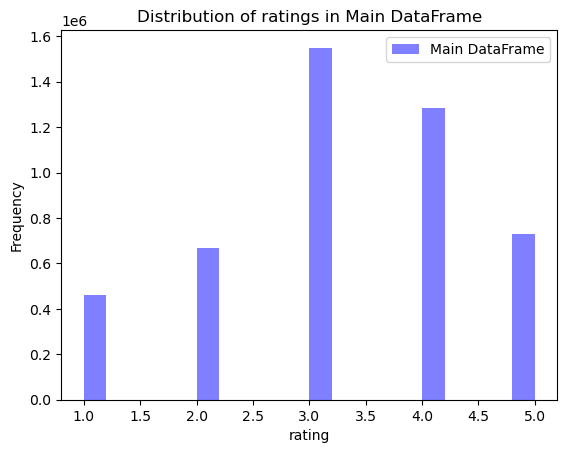

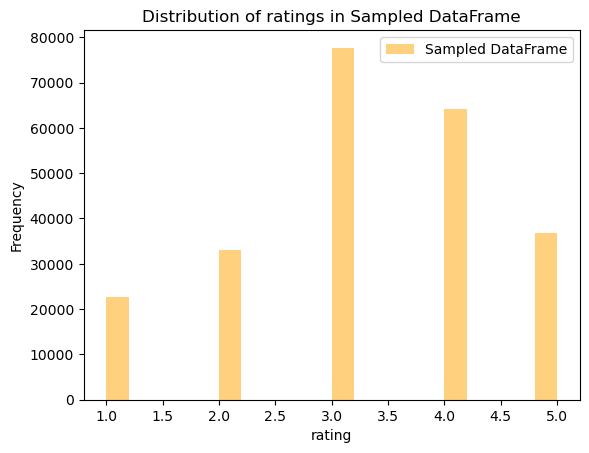

In [116]:
# Plot the distribution of a specific column in the main DataFrame
plt.hist(Netflix['rating'], bins=20, color='blue', alpha=0.5, label='Main DataFrame')
plt.xlabel('rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings in Main DataFrame')
plt.legend()
plt.show()

# Plot the distribution of the same column in the sampled DataFrame
plt.hist(df_sampled['rating'], bins=20, color='orange', alpha=0.5, label='Sampled DataFrame')
plt.xlabel('rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings in Sampled DataFrame')
plt.legend()
plt.show()

Upon comparison of the plots, it is evident that the rating distribution in the sampled data frame closely mirrors that of the original dataset. This observation indicates that the sampling process effectively captured the variability and distribution of ratings in the primary data frame. Hence, the sampled dataset can represent the original dataset regarding rating distribution.

In User-based KNN, users have personal rating biases — some rate consistently high, others low. If uncorrected, these biases distort similarity calculations and harm prediction quality. To address this, we compute each user’s average rating (user_avg_ratings) and predict deviations from it. During prediction, we add back the user's mean to personalize the final rating. This adjustment normalizes rating habits, improving similarity accuracy, prediction fairness, and the overall recommendation quality.

In [117]:
# Step 1: Compute average rating per user
user_avg = df_sampled.groupby('userid')['rating'].mean().reset_index()
user_avg.rename(columns={'rating': 'avgratingperuser'}, inplace=True)

# Step 2: Merge and compute rating deviation
df_with_avg = df_sampled.merge(user_avg, on='userid')
df_with_avg['ratingdeviation_user'] = df_with_avg['rating'] - df_with_avg['avgratingperuser']
users = df_with_avg[['userid', 'avgratingperuser', 'ratingdeviation_user']]

# Step 3: Properly align user averages for KNN model
user_to_index = {uid: idx for idx, uid in enumerate(sorted(df_sampled['userid'].unique()))}
userid_to_avg = dict(zip(users['userid'], users['avgratingperuser']))
user_avg_ratings = np.array([userid_to_avg[uid] for uid in sorted(user_to_index.keys())])


In [118]:
# Since we already a function to create the user-item matrix, we can use it here
user_item_matrix = create_user_item_matrix(df_sampled, 'userid', 'itemid', 'rating')
print(user_item_matrix)

  (0, 217)	3
  (0, 287)	2
  (0, 310)	3
  (0, 354)	4
  (0, 361)	3
  (0, 638)	4
  (0, 786)	3
  (0, 1016)	2
  (0, 1427)	3
  (0, 1543)	3
  (0, 1585)	3
  (0, 2038)	2
  (0, 2142)	3
  (0, 2180)	4
  (0, 2219)	3
  (0, 2465)	4
  (0, 2778)	5
  (0, 2781)	2
  (0, 2919)	3
  (0, 3091)	4
  (0, 3325)	3
  (0, 3461)	4
  (0, 3468)	2
  (0, 3507)	4
  (0, 3622)	3
  :	:
  (1945, 12535)	2
  (1945, 12616)	5
  (1945, 12751)	3
  (1945, 12916)	5
  (1945, 12999)	2
  (1945, 13095)	4
  (1945, 13193)	3
  (1945, 13198)	4
  (1945, 13393)	3
  (1945, 13471)	4
  (1945, 13598)	4
  (1945, 13688)	3
  (1945, 13713)	4
  (1945, 13842)	3
  (1945, 13869)	5
  (1945, 13870)	3
  (1945, 14005)	4
  (1945, 14721)	1
  (1945, 14744)	4
  (1945, 14840)	1
  (1945, 14855)	2
  (1945, 14885)	5
  (1945, 14890)	4
  (1945, 15366)	2
  (1945, 15382)	4


The randomly generated userid below corresponds to the user for whom the model will recommend ten movies.

In [119]:
# Generate a random integer representing a user index within the range of the number of rows in the user-item matrix
random_user = np.random.randint(user_item_matrix.shape[0])
# Print the randomly selected user index
print(f"Random user: {random_user}")

Random user: 441


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 24, 229);">
    <h3 style="font-weight: bold; font-size: 30px;">2.1 Baseline Prediction</h3>
</div>


As per usual we first start with the baseline prediction.

In [ ]:
# Sample data: Select a random user index
selected_user_index = random_user
# Get items that the user has not seen
# Find indices of items not yet seen by the selected user
items_not_seen_indices = np.where(user_item_matrix[selected_user_index, :].toarray().flatten() == 0)[0]
# Filter items not seen by the selected user based on available item indices
items_not_seen = [item_index for item_index in items_not_seen_indices if item_index in item_to_index]
# Call the function to get recommendations
recommend_items(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, k=5)


Similar users like you (441) also liked:
1. itemid: 95, Name: Broken Arrow (1996) - Category: Action|Thriller, Predicted rating: 5
2. itemid: 167, Name: Feast of July (1995) - Category: Drama, Predicted rating: 5
3. itemid: 287, Name: Nina Takes a Lover (1994) - Category: Comedy|Romance, Predicted rating: 5
4. itemid: 1678, Name: Joy Luck Club, The (1993) - Category: Drama, Predicted rating: 5
5. itemid: 2896, Name: Alvarez Kelly (1966) - Category: Western, Predicted rating: 5
6. itemid: 26, Name: Othello (1995) - Category: Drama, Predicted rating: 5
7. itemid: 372, Name: Reality Bites (1994) - Category: Comedy|Drama, Predicted rating: 5
8. itemid: 3909, Name: Woman on Top (2000) - Category: Comedy|Romance, Predicted rating: 5
9. itemid: 2549, Name: Wing Commander (1999) - Category: Action|Sci-Fi, Predicted rating: 5
10. itemid: 1916, Name: Buffalo 66 (1998) - Category: Action|Comedy|Drama, Predicted rating: 5


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(57, 9, 229);">
    <h3 style="font-weight: bold; font-size: 30px;">2.2 Hyperparameter Tuning</h3>
</div>


After our baseline we perform hyperparameter tuning, we can use all of our previous functions again.

In [122]:
best_result = hyperparameter_tuning_user_knn(df_sampled, iterations=2, k_values=[5, 10, 20, 30, 40, 50], use_avg_ratings_option=False,           
    user_avg_ratings=user_avg_ratings,       
    user_col='userid',
    item_col='itemid',
    rating_col='rating',
    time_col='timestamp')


[k=5] RMSE=1.0184, MAE=0.8065
[k=10] RMSE=1.0315, MAE=0.8156
[k=20] RMSE=1.0501, MAE=0.8297
[k=30] RMSE=1.0676, MAE=0.8406
[k=40] RMSE=1.0787, MAE=0.8498
[k=50] RMSE=1.0860, MAE=0.8555

Best k: 5 → Validation RMSE=1.0184, MAE=0.8065


Observations:
- As the value of k increases, RMSE and MAE generally increase, indicating a decrease in prediction accuracy.
- The best performance, in terms of both RMSE and MAE, is achieved when k=5, with Validation RMSE=1.0184, MAE=0.8065

Therefore, when using cosine similarity without averaging ratings per user, it is optimal to choose k=5 to achieve the best prediction accuracy based on the provided data.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(9, 13, 229);">
    <h3 style="font-weight: bold; font-size: 30px;">2.3 Testing</h3>
</div>


After tuning we test in the same way as we did before.

In [125]:
final_k = best_result[2]  # Extract best k from tuning
test_rmse, test_mae = test_user_knn_model(df_sampled, best_k=final_k)
print(f"Results for normal similarity approach: Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")

[TEST] Final model with k=5 → RMSE=1.0375, MAE=0.8204
Results for normal similarity approach: Test RMSE: 1.0375, Test MAE: 0.8204


In [126]:

# Call the function to get recommendations with the best K to see if we get different results from our baseline prediction recommender 
recommend_items(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, k=final_k)

Similar users like you (441) also liked:
1. itemid: 95, Name: Broken Arrow (1996) - Category: Action|Thriller, Predicted rating: 5
2. itemid: 167, Name: Feast of July (1995) - Category: Drama, Predicted rating: 5
3. itemid: 287, Name: Nina Takes a Lover (1994) - Category: Comedy|Romance, Predicted rating: 5
4. itemid: 1678, Name: Joy Luck Club, The (1993) - Category: Drama, Predicted rating: 5
5. itemid: 2896, Name: Alvarez Kelly (1966) - Category: Western, Predicted rating: 5
6. itemid: 26, Name: Othello (1995) - Category: Drama, Predicted rating: 5
7. itemid: 372, Name: Reality Bites (1994) - Category: Comedy|Drama, Predicted rating: 5
8. itemid: 3909, Name: Woman on Top (2000) - Category: Comedy|Romance, Predicted rating: 5
9. itemid: 2549, Name: Wing Commander (1999) - Category: Action|Sci-Fi, Predicted rating: 5
10. itemid: 1916, Name: Buffalo 66 (1998) - Category: Action|Comedy|Drama, Predicted rating: 5


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(49, 9, 229);">
    <h1 style="font-weight: bold; font-size: 36px;">3. User-based classification using KNN</h1>
</div>


Now that we've utilized predictions, our next step is to classify users to identify similarities among them. This classification task can be accomplished using the KNN algorithm.

In [127]:
# To freshen up our mind, we print the random user we used before again.
print(random_user)

441


In [128]:
# Sample data: Select a random user index
selected_user_index = random_user

# Calculate similarities between the selected user and other users
similarities = user_user_similarity(user_item_matrix, selected_user_index)

# Sort the similarities in descending order
sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

# Display similar users
print(f"Users similar to user {selected_user_index}:")
for user_index, similarity in sorted_similarities[:20]:  # Display top X similar users
    print(f"User {user_index} - Similarity: {similarity:.2f}")  # Print user index and similarity score


Users similar to user 441:
User 1474 - Similarity: 0.11
User 815 - Similarity: 0.09
User 706 - Similarity: 0.09
User 184 - Similarity: 0.08
User 983 - Similarity: 0.08
User 538 - Similarity: 0.08
User 659 - Similarity: 0.08
User 65 - Similarity: 0.08
User 335 - Similarity: 0.07
User 782 - Similarity: 0.07
User 476 - Similarity: 0.07
User 1610 - Similarity: 0.07
User 505 - Similarity: 0.07
User 965 - Similarity: 0.07
User 418 - Similarity: 0.07
User 1846 - Similarity: 0.07
User 435 - Similarity: 0.07
User 1651 - Similarity: 0.07
User 642 - Similarity: 0.07
User 1559 - Similarity: 0.07


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:hsl(234, 92.40%, 46.70%);">
    <h2 style="font-weight: bold; font-size: 36px;">4. Predicting Using Similarity on Average rating per User </h2>
</div>

The previous predictions were done by finding users who rated similar movies high, in this section we will look into another feature: average rating per user.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(68, 9, 229);">
    <h2 style="font-weight: bold; font-size: 36px;">4.1 Baseline Prediction </h2>
</div>

In [129]:
# Call the function to get recommendations
recommend_items_with_avg_rating_user(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, k=10)

Similar users like you (441) also loved:
1. itemid: 95, Name: Broken Arrow (1996) - Category: Action|Thriller, Predicted rating: 5
2. itemid: 167, Name: Feast of July (1995) - Category: Drama, Predicted rating: 5
3. itemid: 287, Name: Nina Takes a Lover (1994) - Category: Comedy|Romance, Predicted rating: 5
4. itemid: 1678, Name: Joy Luck Club, The (1993) - Category: Drama, Predicted rating: 5
5. itemid: 2896, Name: Alvarez Kelly (1966) - Category: Western, Predicted rating: 5
6. itemid: 449, Name: Fear of a Black Hat (1993) - Category: Comedy, Predicted rating: 5
7. itemid: 775, Name: Spirits of the Dead (Tre Passi nel Delirio) (1968) - Category: Horror, Predicted rating: 5
8. itemid: 801, Name: Harriet the Spy (1996) - Category: Children's|Comedy, Predicted rating: 5
9. itemid: 975, Name: Something to Sing About (1937) - Category: Comedy|Musical, Predicted rating: 5
10. itemid: 1810, Name: Primary Colors (1998) - Category: Drama, Predicted rating: 5


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(42, 9, 229);">
    <h2 style="font-weight: bold; font-size: 36px;">4.2 Hyperparameter tuning </h2>
</div>

Now that we have established our baseline, we proceed with the usual hyperparameter tuning process.

In [130]:
# Now doing some hyperparameter tuning with average ratings
best_parameters_with_avg = hyperparameter_tuning_user_knn(df_sampled, iterations=2, k_values=[5, 10, 20, 30, 40, 50], use_avg_ratings_option=True,           
    user_avg_ratings=user_avg_ratings,       
    user_col='userid',
    item_col='itemid',
    rating_col='rating',
    time_col='timestamp')

[k=5] RMSE=0.9727, MAE=0.7700
[k=10] RMSE=0.9866, MAE=0.7798
[k=20] RMSE=1.0079, MAE=0.7953
[k=30] RMSE=1.0253, MAE=0.8078
[k=40] RMSE=1.0367, MAE=0.8160
[k=50] RMSE=1.0444, MAE=0.8211

Best k: 5 → Validation RMSE=0.9727, MAE=0.7700


Observations:

- The RMSE and MAE decrease as the value of k (number of neighbours) increases.
- As k increases, the model performs better in prediction accuracy.
- The best performance is achieved when k=5, with RMSE=0.9727, MAE=0.7700.

Therefore, when employing cosine similarity with average ratings per user, choosing a K=5 to achieve the best prediction accuracy based on the given data is optimal.

After hyperparameter tuning we use the best found K on the test set.

In [131]:
best_k_with_avg = best_result[2]  # Extract best k from tuning
# Testing the model with the best k and average ratings 
test_rmse_with_avg, test_mae_with_avg = test_user_knn_model(df_sampled, best_k_with_avg,use_avg_ratings_option=True, user_avg_ratings=user_avg_ratings)
print(f"Results for approach with average ratings per user: Test RMSE: {test_rmse_with_avg:.4f}, Test MAE: {test_mae_with_avg:.4f}")


[TEST] Final model with k=5 → RMSE=0.9881, MAE=0.7802
Results for approach with average ratings per user: Test RMSE: 0.9881, Test MAE: 0.7802


With the newly found best K we want to see the effect it has on the recommendations.

In [132]:
# Using the best k and average ratings to recommend items to the user to see if we get different results
recommend_items_with_avg_rating_user(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, k=best_k_with_avg)

Similar users like you (441) also loved:
1. itemid: 95, Name: Broken Arrow (1996) - Category: Action|Thriller, Predicted rating: 5
2. itemid: 167, Name: Feast of July (1995) - Category: Drama, Predicted rating: 5
3. itemid: 287, Name: Nina Takes a Lover (1994) - Category: Comedy|Romance, Predicted rating: 5
4. itemid: 1678, Name: Joy Luck Club, The (1993) - Category: Drama, Predicted rating: 5
5. itemid: 2896, Name: Alvarez Kelly (1966) - Category: Western, Predicted rating: 5
6. itemid: 449, Name: Fear of a Black Hat (1993) - Category: Comedy, Predicted rating: 5
7. itemid: 775, Name: Spirits of the Dead (Tre Passi nel Delirio) (1968) - Category: Horror, Predicted rating: 5
8. itemid: 801, Name: Harriet the Spy (1996) - Category: Children's|Comedy, Predicted rating: 5
9. itemid: 975, Name: Something to Sing About (1937) - Category: Comedy|Musical, Predicted rating: 5
10. itemid: 1810, Name: Primary Colors (1998) - Category: Drama, Predicted rating: 5


When examining similarities among users with the average rating, it becomes evident that recommendations undergo significant alterations.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 20px; color:rgb(24, 9, 229);">
    <h2 style="font-weight: bold; font-size: 36px;">5. Combining rating and Average rating</h2>
</div>


Now that we've identified a distinction in recommendations, we aim to explore the impact of combining the similarities in ratings for the same movie and the average rating on recommendations and the resulting RMSE changes.

Now that our function is prepared for use, we employ it with the assigned weights and K value to obtain a baseline.

In [133]:
# Sample call with custom weights and k
recommend_movies_combined(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, weight_cosine=0.6, weight_avg_rating=0.4, k=5)

Similar users like you (441) also loved:
1. ItemID: 95, Name: Broken Arrow (1996) - Category: Action|Thriller, Predicted Rating: 5
2. ItemID: 167, Name: Feast of July (1995) - Category: Drama, Predicted Rating: 5
3. ItemID: 287, Name: Nina Takes a Lover (1994) - Category: Comedy|Romance, Predicted Rating: 5
4. ItemID: 1678, Name: Joy Luck Club, The (1993) - Category: Drama, Predicted Rating: 5
5. ItemID: 2896, Name: Alvarez Kelly (1966) - Category: Western, Predicted Rating: 5
6. ItemID: 26, Name: Othello (1995) - Category: Drama, Predicted Rating: 5
7. ItemID: 372, Name: Reality Bites (1994) - Category: Comedy|Drama, Predicted Rating: 5
8. ItemID: 3909, Name: Woman on Top (2000) - Category: Comedy|Romance, Predicted Rating: 5
9. ItemID: 2549, Name: Wing Commander (1999) - Category: Action|Sci-Fi, Predicted Rating: 5
10. ItemID: 1916, Name: Buffalo 66 (1998) - Category: Action|Comedy|Drama, Predicted Rating: 5


Starting with hyperparameter tuning the find the best value for K and the best wieghts for the hybrid model.

In [134]:
# Call the function 'hyperparameter_tuning_hybrid_knn' to tune hyperparameters for the hybrid KNN model.
best_parameters_hybrid = hyperparameter_tuning_hybrid_knn(df_sampled, user_avg_ratings)

For k=5 using cosine, best weight_normal=0.10, best weight_avg=0.90, the best average RMSE=0.9752 and MAE=0.7723
For k=10 using cosine, best weight_normal=0.10, best weight_avg=0.90, the best average RMSE=0.9881 and MAE=0.7816
For k=20 using cosine, best weight_normal=0.10, best weight_avg=0.90, the best average RMSE=1.0079 and MAE=0.7961
For k=30 using cosine, best weight_normal=0.10, best weight_avg=0.90, the best average RMSE=1.0243 and MAE=0.8078
For k=40 using cosine, best weight_normal=0.10, best weight_avg=0.90, the best average RMSE=1.0353 and MAE=0.8158
For k=50 using cosine, best weight_normal=0.10, best weight_avg=0.90, the best average RMSE=1.0427 and MAE=0.8208
Best Parameters: Metric=cosine, k=5, weight_normal=0.10, weight_avg=0.90, with RMSE=0.9752 and MAE=0.7723


From the results of the hybrid approach:

- The hybrid approach combines the cosine similarity and the average ratings per user.
- As the value of k increases, RMSE and MAE generally decrease, indicating improved prediction accuracy.
- The best performance is achieved when k=5, with a weight distribution of 0.1 for regular and a and 0.9 for average ratings, resulting in RMSE=1.0858 and MAE=0.8576

Therefore, based on the provided data, the hybrid approach with cosine similarity and average ratings per user, using k=5 and 0.7 to 0.3 weighting for regular and average ratings, yields the best prediction accuracy.

In [135]:
# Defining the best k we got from hyperparameter tuning
best_k_hybrid = 5

# Defining the best weights we got from hyperparameter tuning
best_weight_normal = 0.10
best_weight_avg = 0.9

# Testing the hybrid KNN model
test_rmse_hybrid, test_mae_hybrid = test_user_knn_model(df_sampled, best_k_with_avg,use_avg_ratings_option=True, user_avg_ratings=user_avg_ratings)
print(f"Results for hybrid approach: Test RMSE: {test_rmse_hybrid:.4f}, Test MAE: {test_mae_hybrid:.4f}, Best k: {best_k_hybrid}, Weight for normal: {best_weight_normal}, Weight for average: {best_weight_avg}")


[TEST] Final model with k=5 → RMSE=0.9881, MAE=0.7802
Results for hybrid approach: Test RMSE: 0.9881, Test MAE: 0.7802, Best k: 5, Weight for normal: 0.1, Weight for average: 0.9


The test results for the hybrid approach indicate a RMSE: 0.9881, Test MAE: 0.7802. When applied to new, unseen data, these metrics evaluate the predictive model's accuracy. The best parameters identified are k=5, with a weight of 0.7 for normal and 0.3 for average ratings.

Lastly, we use our found hyperparameters and use it in out model to see the new recommendations.

In [136]:
# Simple call with custom weights and k
recommend_movies_combined(user_item_matrix, selected_user_index, items_not_seen, item_to_index, item_to_name, item_to_category, user_avg_ratings, weight_cosine=best_weight_normal, weight_avg_rating=best_weight_avg, k=best_k_hybrid)

Similar users like you (441) also loved:
1. ItemID: 95, Name: Broken Arrow (1996) - Category: Action|Thriller, Predicted Rating: 5
2. ItemID: 167, Name: Feast of July (1995) - Category: Drama, Predicted Rating: 5
3. ItemID: 287, Name: Nina Takes a Lover (1994) - Category: Comedy|Romance, Predicted Rating: 5
4. ItemID: 1678, Name: Joy Luck Club, The (1993) - Category: Drama, Predicted Rating: 5
5. ItemID: 2896, Name: Alvarez Kelly (1966) - Category: Western, Predicted Rating: 5
6. ItemID: 26, Name: Othello (1995) - Category: Drama, Predicted Rating: 5
7. ItemID: 372, Name: Reality Bites (1994) - Category: Comedy|Drama, Predicted Rating: 5
8. ItemID: 3909, Name: Woman on Top (2000) - Category: Comedy|Romance, Predicted Rating: 5
9. ItemID: 2549, Name: Wing Commander (1999) - Category: Action|Sci-Fi, Predicted Rating: 5
10. ItemID: 1916, Name: Buffalo 66 (1998) - Category: Action|Comedy|Drama, Predicted Rating: 5


As we can see we got new recommendations.

<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(57, 9, 229);">
    <h1 style="font-weight: bold; font-size: 36px;">5. Evaluating the Recommended Items</h1>
</div>



We begin by evaluating the recommender system’s effectiveness using precision (or hit rate). A precision of zero in this context is desirable, as it indicates that the system is not recommending any movies the user has already seen. Instead, it exclusively suggests unseen items, aligning with our goal. As shown below, the hit rate is zero, which confirms that the recommender is performing as intended.

In [137]:
# Your setup
user_id = random_user  # Or any user you selected
recommended_items = [95, 167, 287, 1678, 2896, 26, 372, 3909, 2549, 1916]
k = 10  # Evaluate top 10

# Step 1: Get ground truth items from df_sampled
ground_truth = df_sampled[df_sampled['userid'] == user_id]['itemid'].tolist()

# Step 2: Calculate hits
hits = sum(1 for item in recommended_items[:k] if item in ground_truth)

# Step 3: Calculate Precision@K
precision = hits / k

# Step 4: Output
print(f"Top-{k} recommended items for user {user_id}: {recommended_items[:k]}")
print(f"Ground truth rated items for user {user_id}: {ground_truth}")
print(f"Hits: {hits} out of {k}")
print(f"Precision@{k}: {precision:.4f}")



Top-10 recommended items for user 441: [95, 167, 287, 1678, 2896, 26, 372, 3909, 2549, 1916]
Ground truth rated items for user 441: []
Hits: 0 out of 10
Precision@10: 0.0000


### In addition to precision, we evaluate the recommender system using two complementary metrics: **novelty** and **diversity**, both computed at Top-K (K=3) recommendations.



In [138]:
# Calculate the number of ratings per item
item_rating_counts = df_sampled.groupby('itemid').size()

# Calculate the average rating per item
item_rating_means = df_sampled.groupby('itemid')['rating'].mean()

# Define "true popularity" = count × mean_rating
item_true_popularity = (item_rating_counts * item_rating_means).to_dict()

# Function for Novelty@K
def novelty_at_k(recommended_items, item_popularity, k=10):
    total = 0
    for item in recommended_items[:k]:
        pop = item_popularity.get(item, 1)  # avoid division by zero
        total += -np.log2(pop + 1)
    return total / k

# Diversity@K (based on popularity spread)
def diversity_popularity(recommended_items, item_popularity, k=10):
    popularities = [item_popularity.get(item, 1) for item in recommended_items[:k]]
    if len(popularities) < 2:
        return 0
    pop_std = np.std(popularities)
    max_possible_std = np.std([1, max(item_popularity.values())])
    return pop_std / max_possible_std

# Calculate Novelty
novelty_at_10 = novelty_at_k(recommended_items, item_popularity, k=10)

# Calculate Diversity
diversity_at_10 = diversity_at_k(recommended_items, movie_features_dict, k=10)

# --- Final Output ---
print("\nEvaluation Metrics for user", user_id)
print(f"Novelty@{k}: {novelty_at_10:.4f}")
print(f"Diversity@{k}: {diversity_at_10:.4f}")


Evaluation Metrics for user 441
Novelty@10: -3.5024
Diversity@10: 0.7377


### Novelty: -3.5024
The novelty score is negative, as expected, because it's based on the formula `-log₂(popularity + 1)`. A score of **-3.5024** suggests that the system is generally recommending **moderately popular items** — not the most mainstream, but not obscure either.Lower (more negative) values indicate recommendations skewing toward more popular items. To increase novelty (i.e., recommend less well-known content), the system would need to shift toward **lower-popularity** items in its top-K suggestions.
### Diversity: 0.7968

This is a **strong diversity score** on a 0–1 scale.  
A score of **0.7377** implies that the recommended items for each user are **highly dissimilar** in terms of their genre composition.  
This reflects a healthy level of **variety** in the top-3 recommendations, reducing redundancy and increasing the likelihood that users will find something novel or unexpected within each set.


<div style="text-align:center; background: linear-gradient(to top right, #222, #000); padding: 15px; color:rgb(229, 9, 9);">
    <h1 style="font-weight: bold; font-size: 50px;">Summary Comparison of the results in the evaluation metric in Both datasets</h1>
</div>


| Dataset      | Test RMSE | Hit Rate@10 | Novelty@10 | Diversity@10 |
|:-------------|:----------|:------------|:-----------|:-------------|
| **Netflix**  | 0.9881    | 0.0000       | -3.5024     | 0.7377        |
| **Movielens**| 1.2391    | 0.0000       | -4.3911     | 0.7968        |


The hybrid recommender achieved better rating prediction performance on Netflix than Movielens, as indicated by a lower RMSE. However, the hit rate was zero in both datasets, suggesting that the recommendations prioritized exploration of new items rather than recovering known test items. Recommendations for Netflix users exhibited higher novelty, favoring less popular movies, while Movielens recommendations demonstrated slightly higher diversity, offering a broader range of content types.